# Car-following plots for sensitivity analysis

This notebook was written by Evangelos Paschalidis (evangelos.paschalidis@epfl.ch) for the Decision-aid methodologies in transportation course at EPFL (http://edu.epfl.ch/coursebook/en/decision-aid-methodologies-in-transportation-CIVIL-557). 

Please contact before distributing or reusing the material below.

## Overview

This notebook covers the estimation of a linear regression model in python with maximum likelihhod estimation:

* Load necessary packages
* Define variables to use for plots
* Syntax for plots

Have a go at working through the notebook. To run a code cell, just click on it (to see a green box around it) and then press the **Run** button at the top! 

Some cells have blank lines for you to complete. There is always a comment telling you what to do!

You can also add a new cell by pressing the **+** button at the top of the page.

## Load packages

As usually, let's load some packages that we are going to need. When importing a package, it is common to rename it using an abbreviation.

In [1]:
import pandas as pd # Usual suspect #1
import numpy as np # Usual suspect #2
import matplotlib.pyplot as plt # Package that will help us plot

## Load data

We need to load two different files
* The traffic data that we used for the estimation of the car-following models
* The parameter estimates (results) for which we need to plot

### Load traffic data

In [2]:
df = pd.read_table('Project_data/US101_data1.txt')

### Load parameter estimates

We take these from the csv file that is automatically created when we estimate a model

In [3]:
data = pd.read_csv("car_following_model_US101_results.csv")
print(data)

   Parameter  Estimate   s.e.  t-ratio0  p-value  Rob s.e.  Rob t-ratio0  \
0  alpha_acc     0.627  0.262     2.394    0.017     0.275         2.283   
1  alpha_dec    -6.147  2.576    -2.386    0.017     3.163        -1.944   
2   beta_acc    -0.045  0.077    -0.579    0.562     0.086        -0.523   
3   beta_dec    -0.096  0.075    -1.291    0.197     0.068        -1.428   
4  gamma_acc     0.049  0.110     0.443    0.658     0.121         0.402   
5  gamma_dec     0.645  0.128     5.033    0.000     0.145         4.453   
6  lamda_acc     0.578  0.047    12.231    0.000     0.050        11.530   
7  lamda_dec     0.595  0.063     9.477    0.000     0.061         9.721   
8  sigma_acc     0.373  0.007    52.589    0.000     0.010        37.663   
9  sigma_dec     0.403  0.008    49.322    0.000     0.011        36.572   

   Rob p-value  
0        0.022  
1        0.052  
2        0.601  
3        0.153  
4        0.688  
5        0.000  
6        0.000  
7        0.000  
8        0

### Parameter estimates data process

Before using the parameter estimates values we need to process the data and convert to an easy to use format.

There is no need to change anything in the cell below.

In [4]:
# Create a dictionary  with the parameter estimates #
names = data.iloc[:,0] # parameter names
parameters = data.iloc[:,1] # parameter values
parameters = parameters.to_dict() # convert values to dictionary
parameters = dict(zip(names, list(parameters.values()))) # add parameter names
del[names] # delete the names series

# Convert to data frame and transpose (it makes our life easier to transfer the parameters to the global environment)
parameters = pd.DataFrame.from_dict(parameters, orient = 'index')
parameters = pd.DataFrame.transpose(parameters)

# Transfer parameters to the global environment
for col in parameters.columns:
    globals()[col] = np.array(parameters[col])[0]
del[col]

## Generate variables

In order to plot we need our variables in two different formats:
* The mean values
* A sequence of *n* numbers in the min,max range observed in the data

For example, taking speed into account we need (a) the mean speed in the data and (b) *n* (let's say 1000) values of speed that start from the minimum speed (as observed in the data) to the maximum speed (as observed in the data again)

#### The general approach is:

Let's say we want to plot acceleration (or deceleration) versus speed i.e. how acceleration is changing with speed.

The way we do this is to calculate acceleration values using the same formula that we used to estimate the car-following model.

* We replace the variable of interest (speed in our case) with *n* speed values that we generate based on the min and max speed values observed in the data

* We replace the remaining variables (relative speed and space headway) with the sample mean values. We need these to be constant as we are only interested in the impact of speed all others being equal

* The model also has some parameters. We replace these with the parameter values that we obtained when we estimated our model

* We plot acceleration (or deceleration) versus speed. The result is a line showing the acceleration (or deceleration) pattern as speed increases

* We repated the process above for space headway and relative speed

* Attention! Our model specification is conditional on the sign of relative speed. When we investigate the impact of relative speed we need to generate two different relative speed variables (positive and negative)

### Generate mean values of the variables

In [5]:
# Mean speed
mean_speed = np.mean(df.Speed)

# Mean space headway
mean_space_headway = np.mean(df.Space_headway)

# Mean relative speed (positive and negative)
# Before we calculate the values we need to subset positive and negative cases.
rel_speed = np.array(df.Speed_lead - df.Speed) # Relative speed array
rel_speed_pos = rel_speed[rel_speed>=0] # Subset of positive values
rel_speed_neg = rel_speed[rel_speed<0] # Subset of negative values

mean_rel_speed_pos = np.mean(rel_speed_pos) # Mean of positive values
mean_rel_speed_neg = np.mean(rel_speed_neg) # Mean of negative values

### Generate sequences of variables' values

In [6]:
# First we need to specify how many values we want in our sequences
nobs = 1000

# Now let's create our sequences.
# The command we use is arrange from the numpy package
# arrange takes as input *from* ,*to* and *step*
# To get *n* number of onservations we divide the *to* with *from* difference with *n*

# Speed sequence
speed = np.arange(min(df.Speed)+np.exp(-50), max(df.Speed), (max(df.Speed)-min(df.Speed))/nobs)

# Space headway sequence
space_headway = np.arange(min(df.Space_headway), max(df.Space_headway), (max(df.Space_headway)-min(df.Space_headway))/nobs)

# Relative speed sequence
# Here things are slightly different. We calculate min and max in advance to avoid complexities later in our code.

min_rs = min(df.Speed_lead - df.Speed); max_rs = max(df.Speed_lead - df.Speed)
rel_speed_pos = np.arange(0, max_rs, (max_rs-0)/nobs)
rel_speed_neg = np.arange(min_rs, 0, (0-min_rs)/nobs)

## Time to plot!

### Acceleration vs speed plots

#### Step 1: Define the variables we need

In theory we can directly use the variables using the names we generated previously in the code.

Here, we renamve these to some generic names. If we do this in advance we do not need to specify later which variables are mean values or sequence within the model.

In [7]:
speed_plot = speed # Sequence of speed
space_headway_plot = mean_space_headway # Mean value of space headway
rel_speed_pos_plot = mean_rel_speed_pos # Mean value of positive relative speed
rel_speed_neg_plot = mean_rel_speed_neg # Mean value of negative relative speed

#### Step 2: Calculate the acceleration and deceleration values

To do this we will use the same model specification with the estimation code.

In [8]:
# Acceleration
acc = alpha_acc * ((speed_plot**beta_acc)/(space_headway_plot**gamma_acc)) * abs(rel_speed_pos_plot)**lamda_acc

# Deceleration
dec = alpha_dec * ((speed_plot**beta_dec)/(space_headway_plot**gamma_dec)) * abs(rel_speed_neg_plot)**lamda_dec

#### Step 3: Plot for acceleration

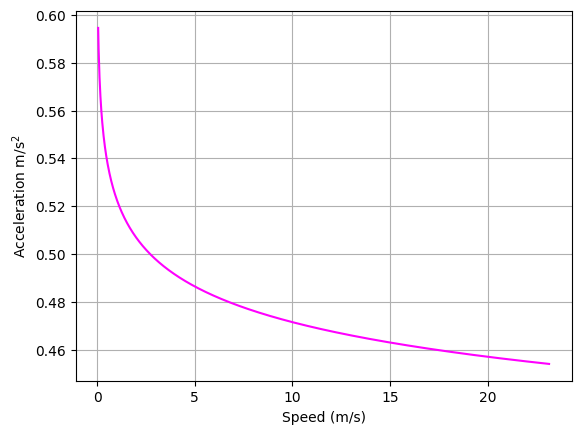

In [9]:
plt.plot(speed_plot,acc,color='magenta') # Set plot variables and colour
plt.xlabel('Speed (m/s)') # Label of x axis
plt.ylabel('Acceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True) # Add grid
plt.savefig('US_acc_speed.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution

#### Step 4: Plot for deceleration

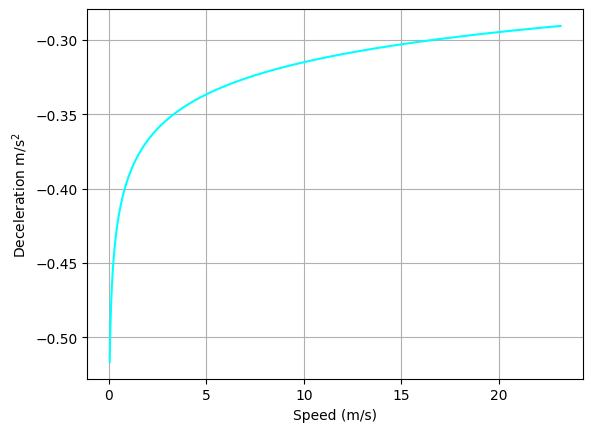

In [10]:
plt.plot(speed_plot,dec,color='cyan') # Set plot variables and colour
plt.xlabel('Speed (m/s)') # Label of x axis
plt.ylabel('Deceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True) # Add grid
plt.savefig('US_dec_speed.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution

### Now we must repeat the same process for space headway 🙄

#### Step 1: Define the variables we need

In [11]:
speed_plot = mean_speed # Mean value of speed
space_headway_plot = space_headway # Sequence of space headway
rel_speed_pos_plot = mean_rel_speed_pos # Mean value of positive relative speed
rel_speed_neg_plot = mean_rel_speed_neg # Mean value of negative relative speed

#### Step 2: Calculate the acceleration and deceleration values

In [12]:
# Acceleration
acc = alpha_acc * ((speed_plot**beta_acc)/(space_headway_plot**gamma_acc)) * abs(rel_speed_pos_plot)**lamda_acc

# Deceleration
dec = alpha_dec * ((speed_plot**beta_dec)/(space_headway_plot**gamma_dec)) * abs(rel_speed_neg_plot)**lamda_dec

#### Step 3: Plot for acceleration

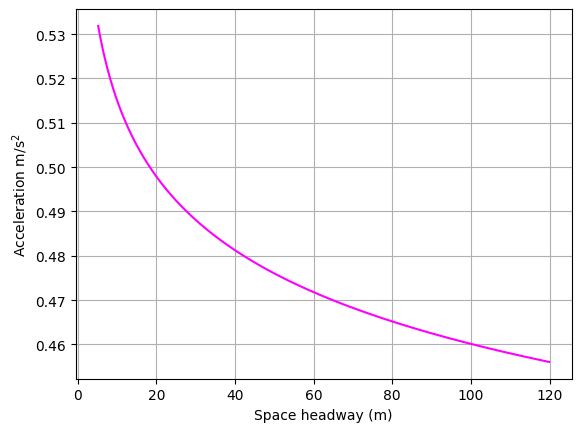

In [13]:
plt.plot(space_headway_plot,acc,color='magenta') # Set plot variables and colour
plt.xlabel('Space headway (m)') # Label of x axis
plt.ylabel('Acceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True) # Add grid
plt.savefig('US_acc_head.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution

#### Step 4: Plot for deceleration

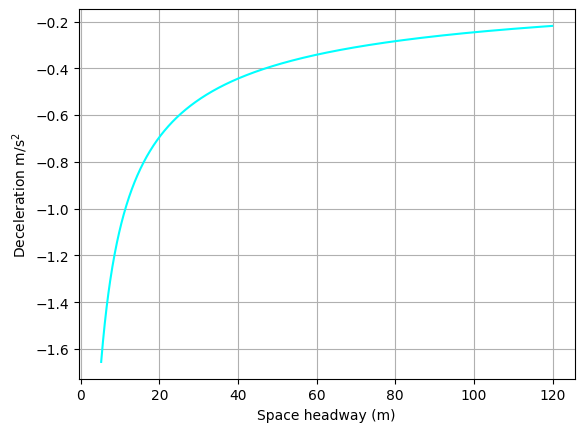

In [14]:
plt.plot(space_headway_plot,dec,color='cyan') # Set plot variables and colour
plt.xlabel('Space headway (m)') # Label of x axis
plt.ylabel('Deceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True)  # Add grid
plt.savefig('US_dec_head.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution

### And now we must repeat the same process for relative speed 😩😩😩

#### Step 1: Define the variables we need

In [15]:
speed_plot = mean_speed # Mean value of speed
space_headway_plot = mean_space_headway # Sequence of space headway
rel_speed_pos_plot = rel_speed_pos # Mean value of positive relative speed
rel_speed_neg_plot = rel_speed_neg # Mean value of negative relative speed

#### Step 2: Calculate the acceleration and deceleration values

In [16]:
# Acceleration
acc = alpha_acc * ((speed_plot**beta_acc)/(space_headway_plot**gamma_acc)) * abs(rel_speed_pos_plot)**lamda_acc

# Deceleration
dec = alpha_dec * ((speed_plot**beta_dec)/(space_headway_plot**gamma_dec)) * abs(rel_speed_neg_plot)**lamda_dec

#### Step 3: Plot for acceleration

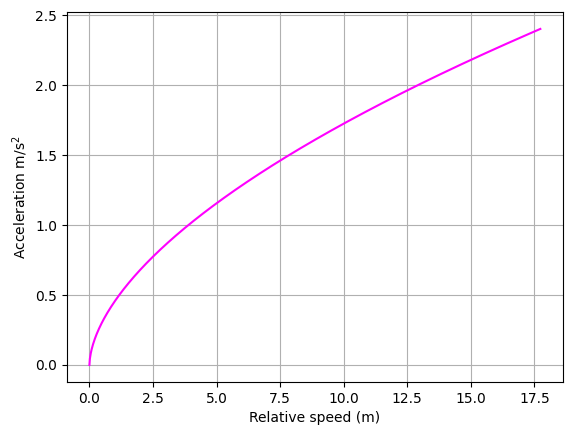

In [17]:
plt.plot(rel_speed_pos_plot,acc,color='magenta') # Set plot variables and colour
plt.xlabel('Relative speed (m)') # Label of x axis
plt.ylabel('Acceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True) # Add grid
plt.savefig('US_acc_rspeed_pos.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution

#### Step 4: Plot for deceleration

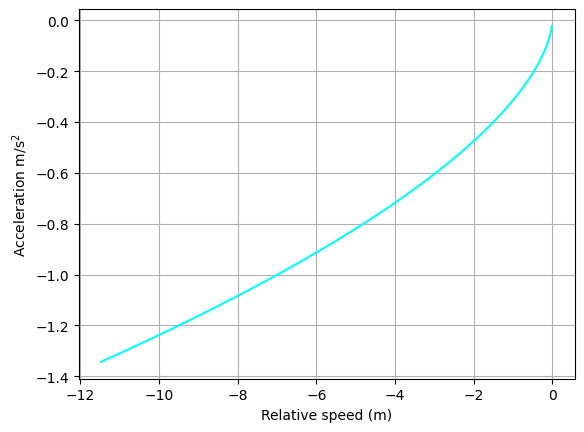

In [18]:
plt.plot(rel_speed_neg_plot,dec,color='cyan') # Set plot variables and colour
plt.xlabel('Relative speed (m)') # Label of x axis
plt.ylabel('Acceleration $\mathregular{m/s^{2}}$') # Label of y axis
plt.grid(True) # Add grid
plt.savefig('US_acc_rspeed_neg.jpg', dpi=300) # Save the plot (name must be changed) and specify resolution